In [0]:
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.naive_bayes as nbyes
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [13]:
# Скачаем файлы базы
!rm -rf /content/DA_data/
!git clone https://github.com/fish34/DA_data.git
!unzip /content/DA_data/courses_cleaned.zip


Cloning into 'DA_data'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.
Archive:  /content/DA_data/courses_cleaned.zip
  inflating: courses_cleaned.csv     


In [0]:
df_all=pd.read_csv("/content/courses_cleaned.csv",index_col=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


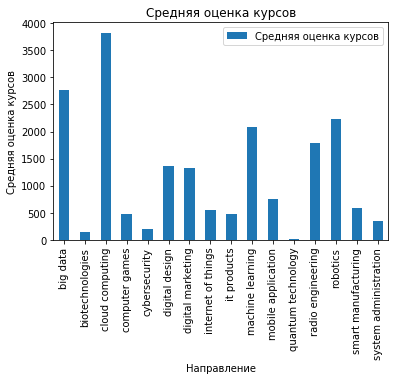

In [17]:
# Выведем на гистограмме среднее значение оценок и рейтинга по каждому направлению
df_all_hist=df_all.groupby(['direction'])['marks'].mean().plot.bar()
ax=plt.axes()
ax.set_xlabel('Направление')
ax.set_ylabel('Средняя оценка курсов')
ax.set_title('Средняя оценка курсов')
ax.legend(labels=['Средняя оценка курсов'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


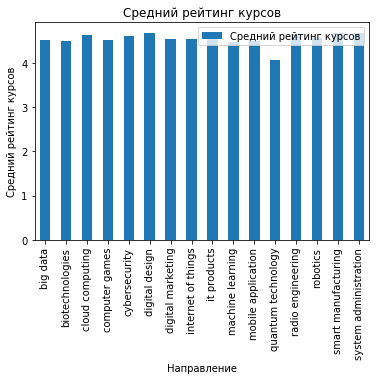

In [18]:
df_all_hist=df_all.groupby(['direction'])['rating'].mean().plot.bar()
ax=plt.axes()
ax.set_xlabel('Направление')
ax.set_ylabel('Средний рейтинг курсов')
ax.set_title('Средний рейтинг курсов')
ax.legend(labels=['Средний рейтинг курсов'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


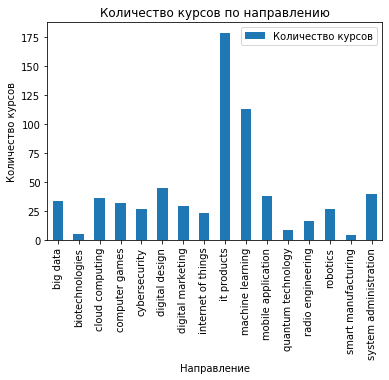

In [19]:
# Отобразим гистограмму количества специализаций и курсов по каждому направлению
df_all_hist=df_all.groupby(['direction'])['direction'].count().plot.bar()
ax=plt.axes()
ax.set_xlabel('Направление')
ax.set_ylabel('Количество курсов')
ax.set_title('Количество курсов по направлению')
ax.legend(labels=['Количество курсов'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


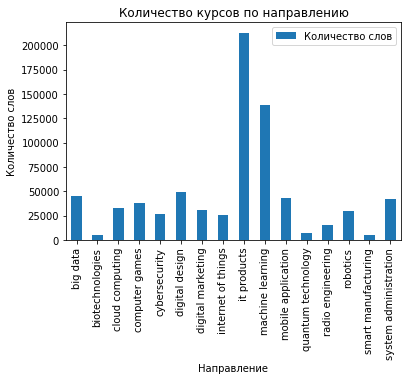

In [20]:
# Отобразим балансировку числа слов от направлений
df_all['words count']=df_all['descr'].str.len()
df_all_hist=df_all.groupby(['direction'])['words count'].sum().plot.bar()
ax=plt.axes()
ax.set_xlabel('Направление')
ax.set_ylabel('Количество слов')
ax.set_title('Количество курсов по направлению')
ax.legend(labels=['Количество слов'])

In [0]:
# Выделим данные для построения модели
courses=df_all[['descr','direction']]

In [77]:
#Закодируем целевую переменную - направление
encoders = {}
encoders['direction'] = preprocessing.LabelEncoder() # для колонки direction создаем кодировщик
courses['direction'] = encoders['direction'].fit_transform(courses['direction']) # применяем кодировщик к столбцу и перезаписываем столбец

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
courses

,descr,direction
0,"['drive', 'better', 'business', 'decisions', '...",0
1,"['interested', 'increasing', 'knowledge', 'big...",8
2,"['identified', 'big', 'data', 'issue', 'analyz...",3
3,"['end', 'course', 'able', 'retrieve', 'data', ...",2
4,"['want', 'make', 'sense', 'volumes', 'data', '...",9
...,...,...
652,"['getting', 'started', 'ibm', 'mainframe', 'zo...",15
653,"['foundational', 'knowledge', 'position', 'ibm...",15
654,"['world', 'runs', 'computers', 'watch', 'tv', ...",15
655,"['effective', 'measures', 'performance', 'asse...",15


In [0]:
#данные для анализа
X=courses['descr'].values
y=courses['direction'].values
print(X)
print(y)
print(X.shape,y.shape)

In [0]:
# Класс для анализа. Используем TF-IDF трансформацию и NB классификатор для полиномиальных моделей
class Classifier():
  def __init__(self,X,y,model = None):
    self.model=model or nbyes.ComplementNB()
    # Разделим выборку на тренировочную и проверочную
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=.15, random_state=33)
    # Трансформируем данные и наполним словарь
    self.vectorizer = TfidfVectorizer(ngram_range = (1,2))
    self.X_train = self.vectorizer.fit_transform(self.X_train)
    self.X_test = self.vectorizer.transform(self.X_test)
    self.future_names = self.vectorizer.get_feature_names()
    self.classifier = self.train_model()
 
  def train_model(self):
    self.model.fit(self.X_train, self.y_train)
  
  def classify(self, text):
    text_counts = self.vectorizer.transform(text)
    self.predictions = self.model.predict(text_counts)
    self.predictions_c = self.model.predict_proba(text_counts)
    print(f'Predictions: {self.predictions}')
    print(f'Predictions for all classes: {self.predictions_c}')
    return self.predictions

  def getReport(self):
    self.y_predictions = self.model.predict(self.X_test)
    print(f'{self.model.__class__.__name__} =', metrics.precision_score(self.y_test, self.y_predictions, pos_label='positive', average='micro'))
    print(classification_report(self.y_test, self.y_predictions))
           
    #ConfMatrix
    fig = plt.figure(figsize=(8,8))
    nn_mtx = metrics.confusion_matrix(self.y_test, self.y_predictions)
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    sns.heatmap(nn_mtx, annot=True, fmt="d", 
                xticklabels=encoders["direction"].classes_,
                yticklabels=encoders["direction"].classes_)
    plt.ylabel("Fact value")
    plt.xlabel("Predicted value")
    print(nn_mtx)   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1259: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ComplementNB = 0.5252525252525253
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           2       1.00      0.67      0.80         6
           3       1.00      0.40      0.57         5
           4       0.50      0.25      0.33         4
           5       0.50      0.20      0.29        10
           6       0.00      0.00      0.00         5
           8       0.38      0.80      0.51        25
           9       0.58      0.64      0.61        22
          10       0.00      0.00      0.00         2
          11       1.00      0.33      0.50         3
          12       1.00      0.50      0.67         2
          13       1.00      0.20      0.33         5
          15       1.00      0.43      0.60         7

    accuracy                           0.53        99
   macro avg       0.67      0.42      0.47        99
weighted avg       0.60      0.53      0.50        99

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 

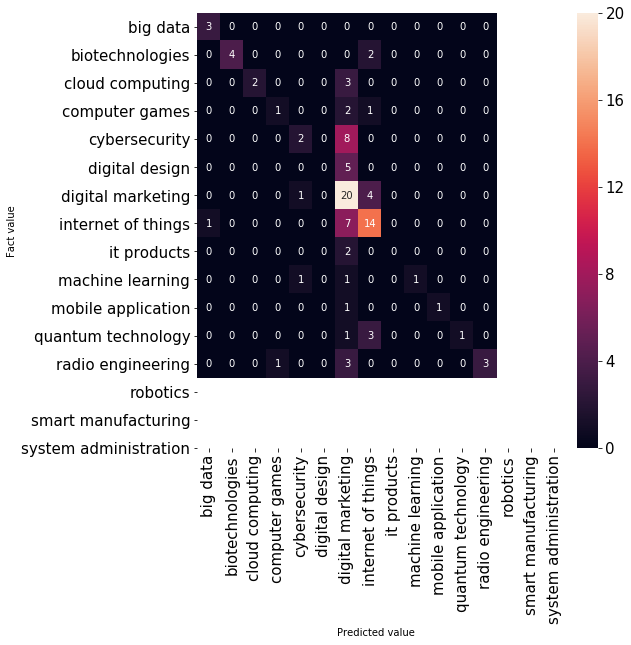

In [93]:
model = Classifier(X,y)
model.getReport()

(array([0.02693603, 0.02693603, 0.02693603, 0.02693603, 0.        ,
        0.35690236, 0.16161616, 0.00673401, 0.01346801, 0.02020202]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

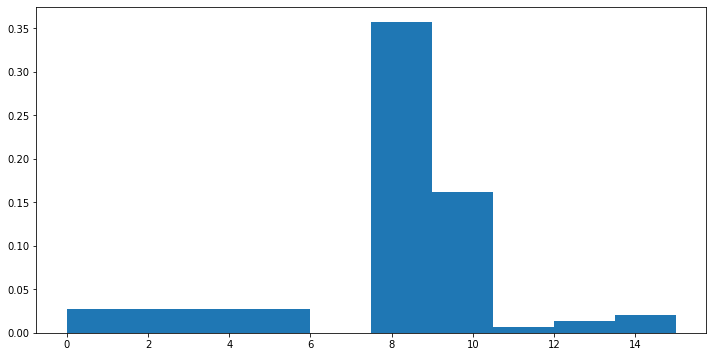

In [44]:
# Отобразим данные тестовых предсказаний на гистограмме
plt.figure(figsize=(12, 6))
plt.hist(model.y_predictions, density=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(array([0.02805836, 0.        , 0.        , 0.        , 0.        ,
        0.02805836, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.08417508, 0.        , 0.02805836, 0.        ,
        0.        , 0.02805836, 0.        , 0.        , 0.11223345,
        0.        , 0.        , 0.05611672, 0.        , 0.        ,
        0.05611672, 0.        , 0.19640853, 0.        , 0.        ,
        1.45903479, 0.        , 0.        , 0.11223345, 0.        ,
        0.        , 0.14029181, 0.        , 0.22446689, 0.        ,
        0.        , 0.05611672, 0.        , 0.        , 0.11223345,
        0.        , 0.        , 0.        , 0.        , 0.05611672]),
 array([-11.  , -10.64, -10.28,  -9.92,  -9.56,  -9.2 ,  -8.84,  -8.48,
         -8.12,  -7.76,  -7.4 ,  -7.04,  -6.68,  -6.32,  -5.96,  -5.6 ,
         -5.24,  -4.88,  -4.52,  -4.16,  -3.8 ,  -3.44,  -3.08,  -2.72,
         -2.36,  -2.  ,  -1.64,  -1.28,  -0.92,  -0.56,  -0.2 ,   0.16,
          0.52,   0.88,   1.24

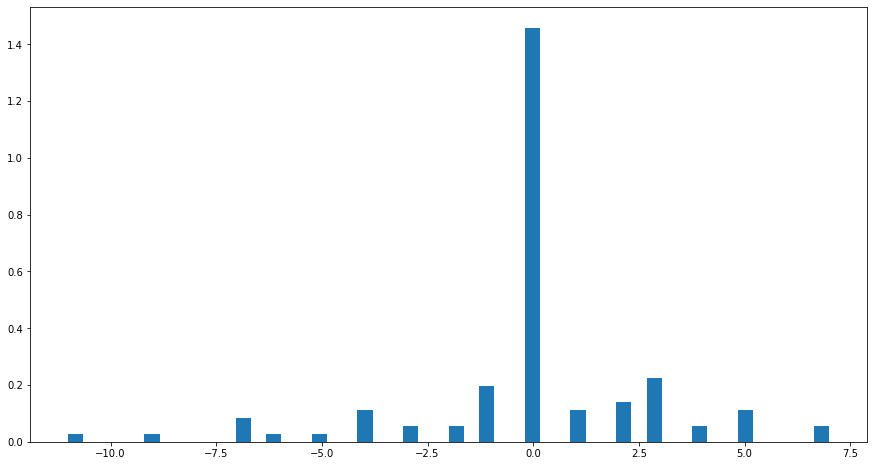

In [45]:
# Отобразим разность предсказаний на гистограмме
diff = model.y_predictions - model.y_test
plt.figure(figsize=(15, 8))
plt.hist(diff, bins=50, normed=True)

In [94]:
# Выполним классификацию по запросу
text = ['i want to learn machine learning']
cls=model.classify(text)
choosed=model.predictions_c
#top_2_idx = sorted(choosed[0])[::-1][:3]
#print(top_2_idx)

Predictions: [9]
Predictions for all classes: [[0.06294746 0.05464694 0.05517892 0.05508528 0.05519026 0.05601244
  0.05515284 0.05569077 0.0615995  0.15284132 0.05519544 0.05481256
  0.05489764 0.06031238 0.05518082 0.05525544]]


In [100]:
# На основе релевантности направлений, сформируем предложение курсов, учитывая их рейтинг и оценки
label=encoders['direction'].inverse_transform(cls)
df_all.loc[df_all['direction']==label[0]].sort_values(['marks','rating'], ascending=False)[['title','marks','rating','url']].head(10)

,title,marks,rating,url
554,Improving Deep Neural Networks: Hyperparameter...,40746.0,4.9,https://www.coursera.org/learn/deep-neural-net...
539,Structuring Machine Learning Projects,33476.0,4.8,https://www.coursera.org/learn/machine-learnin...
537,The Data Scientistâs Toolbox,21170.0,4.5,https://www.coursera.org/learn/data-scientists...
538,Introduction to Data Science in Python,13148.0,4.5,https://www.coursera.org/learn/python-data-ana...
437,Machine Learning Foundations: A Case Study App...,9102.0,4.6,https://www.coursera.org/learn/ml-foundations
395,AI For Everyone,7314.0,4.8,https://www.coursera.org/learn/ai-for-everyone
47,A Crash Course in Data Science,5211.0,4.5,https://www.coursera.org/learn/data-science-co...
504,Machine Learning with Python,4681.0,4.7,https://www.coursera.org/learn/machine-learnin...
548,Machine Learning: Regression,4464.0,4.8,https://www.coursera.org/learn/ml-regression
90,How Google does Machine Learning,4452.0,4.6,https://www.coursera.org/learn/google-machine-...


ТЕСТ

In [0]:
corpus = [
     'This is the first document.',
     'This document is the second document.',
     'And this is the third one.',
     'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.transform(corpus)
print(vectorizer.get_feature_names())

print(X.shape)

  (0, 1)	0.46979138557992045
  (0, 2)	0.5802858236844359
  (0, 6)	0.38408524091481483
  (0, 3)	0.38408524091481483
  (0, 8)	0.38408524091481483
  (1, 5)	0.5386476208856763
  (1, 1)	0.6876235979836938
  (1, 6)	0.281088674033753
  (1, 3)	0.281088674033753
  (1, 8)	0.281088674033753
  (2, 4)	0.511848512707169
  (2, 7)	0.511848512707169
  (2, 0)	0.511848512707169
  (2, 6)	0.267103787642168
  (2, 3)	0.267103787642168
  (2, 8)	0.267103787642168
  (3, 1)	0.46979138557992045
  (3, 2)	0.5802858236844359
  (3, 6)	0.38408524091481483
  (3, 3)	0.38408524091481483
  (3, 8)	0.38408524091481483
[[0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]
 [0.         0.6876236  0.         0.28108867 0.         0.53864762
  0.28108867 0.         0.28108867]
 [0.51184851 0.         0.         0.26710379 0.51184851 0.
  0.26710379 0.51184851 0.26710379]
 [0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]]


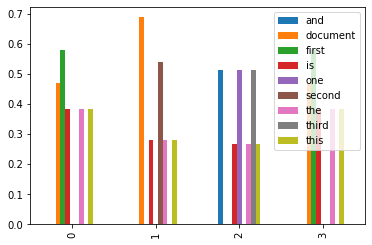

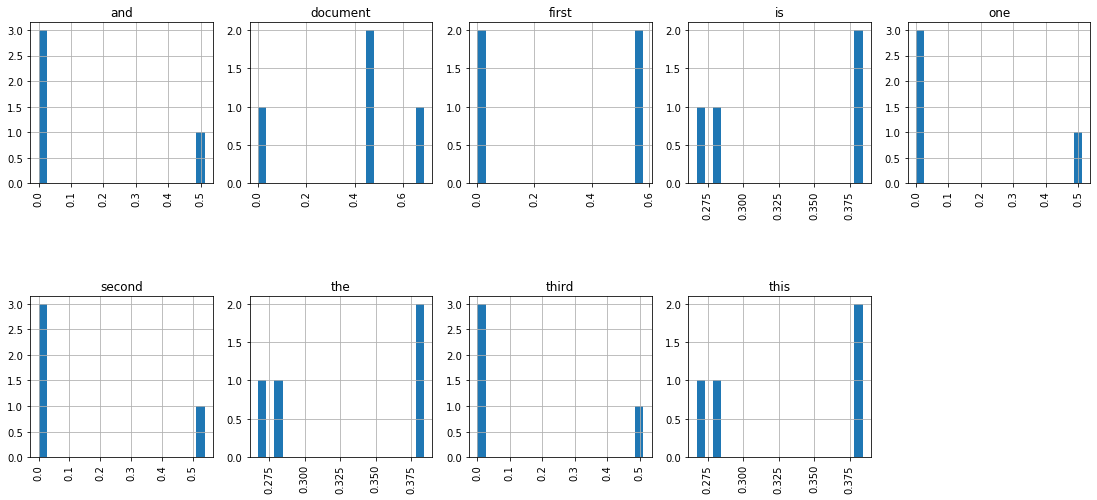

In [0]:
print(X)
doc_matrix = X.todense()
print(doc_matrix)
df = pd.DataFrame(doc_matrix, 
                  columns=vectorizer.get_feature_names(), 
                  index=range(len(corpus)))
df

def plot_df(df):
  fig = plt.figure(figsize=(19,8))
  cols = 5
  rows = np.ceil(float(df.shape[1]) / cols)
  for i, column in enumerate(df.columns):
      ax = fig.add_subplot(rows, cols, i + 1)
      ax.set_title(column)
      df[column].hist(axes=ax,bins=20)
      plt.xticks(rotation="vertical")
  plt.subplots_adjust(hspace=0.7, wspace=0.2)
df.plot.bar()
plot_df(df)

In [0]:
import numpy as np
from sklearn.naive_bayes import ComplementNB
rng = np.random.RandomState(1)
X = rng.randint(5, size=(6, 100))
y = np.array([1, 2, 3, 4, 5, 6])

clf = ComplementNB()
clf.fit(X, y)


TypeError: ignored

In [0]:
import pandas as pd
d={'one':pd.Series([1,['spec','dfdf','dfdffh'],['vdfscvsv','dfsbhsbgdf','dfasddffh','dfasddffh']],),
   'two':pd.Series([1,2,3],)}
df=pd.DataFrame(d,)
df['words count1']=df['one'].str.len()
df

,one,two,words count1
0,1,1,NaN
1,"[spec, dfdf, dfdffh]",2,3.0
2,"[vdfscvsv, dfsbhsbgdf, dfasddffh, dfasddffh]",3,4.0
